# Hierarhical Modeling with Continuous Variables

## Will Koehrsen wjk68

In this notebook we will explore using Markov Chain Monte Carlo methods to solve a hierarchical model. A hierarchical model is one in which an overall process can be subdivided into clusters. This is a natural approach for many real-world problems where variables come from clusters within one larger phenomenon. For example, in this notebook we will look at the relationship between departure and arrival delay for airplane flights in the US. We can look at all of the flights together (known as a pooled model), look at the flights separately by airline - called carriers - (unpooled model), or look at the flights based both on overall statistics and within carrier statistics. Hierarchical modeling allows us to provide a reasonable estimate for a parameter for groups with small sample sizes, such as airlines with few flights. The final estimate will be a weighted average of the overall parameters and the airline parameters, weighted by the number of samples for the group.

### Pooled Model 

In a pooled model, all data comes from the same distribution:

![image](images/pooled.png)

### Unpooled Model

In a completely unpooled model, each group (airline) in this case is treated independently. 

![image](images/unpooled.png)

### Hierarchical Model

In a hierarchical model, the parameters come from a population distribution, which means they are neither completely the same, or completely independent. This allows us to use all observations as well as grouped observations to compute the model parameters.

![image](images/hierarchical.png)

The overall objective of this notebook is to create several hierarchical regression models. We want to find the relationship between the departure delay in minutes and the arrival delay in minutes. My hypothesis is that this should be close to 1, however, some airlines may be better at making up time "in the air". If the slope is less than one between departure delay and arrival delay, that means the flight has made up time while on-route. Perhaps some airlines have a much smaller slope indicating they are consistently better at making up time. We can also use the intercept to model the arrival delay given no departure delay. This might also be useful to compare between airlines. 

In [144]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib 

from IPython.core.pylabtools import figsize
import seaborn as sns
sns.set_context('poster')

%matplotlib inline

import pymc3 as pm

import scipy

# Data Exploration

First we will read in the data and look at the distributions of departure delays and arrival delays. The units are in minutes, and a negative measurement means the flight was early. I will remove the extreme outlying points, those delays longer than 200 minutes. This is so we can approximate the arrival and departure delay times as a normal distribution. Another option would be to take the log of the delays to normalize them. 

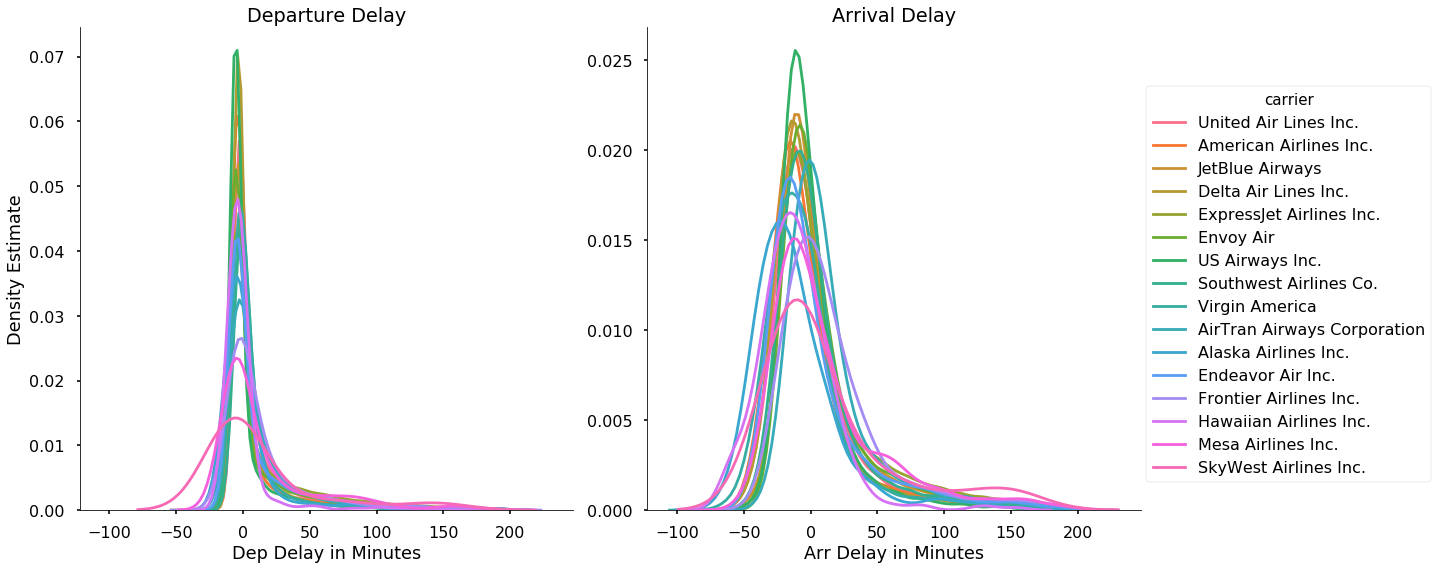

In [87]:
flights = pd.read_csv('data/flights.csv', index_col=0)
flights.dropna(subset=['dep_delay', 'arr_delay'], inplace=True)


carriers = pd.read_csv('data/airlines.csv')
flights = flights.merge(carriers, how = 'left', on = 'carrier' )
flights['carrier'] = flights['name']
flights.drop(columns='name', inplace=True)

flights = flights[(flights.dep_delay < 200) & (flights.arr_delay < 200)]
flights_subset = flights[['carrier', 'dep_delay', 'arr_delay']]
flights_melted = flights_subset.melt(id_vars='carrier', value_name='value', var_name='type')

figsize(16, 8)
grid = sns.FacetGrid(flights_melted, col = 'type', hue = 'carrier', size=8, sharey=False)
grid.map(sns.kdeplot, 'value')
grid.add_legend();
ax1 = grid.axes[0][0]
ax1.set_xlabel('Dep Delay in Minutes')
ax1.set_title('Departure Delay')

ax2 = grid.axes[0][1]
ax2.set_xlabel('Arr Delay in Minutes')
ax2.set_title('Arrival Delay');
ax1.set_ylabel('Density Estimate');

The delays are approximately normal. This will simplify the modeling allow we could also used a skewed normal because the distributions have a rightward, or positive skew.

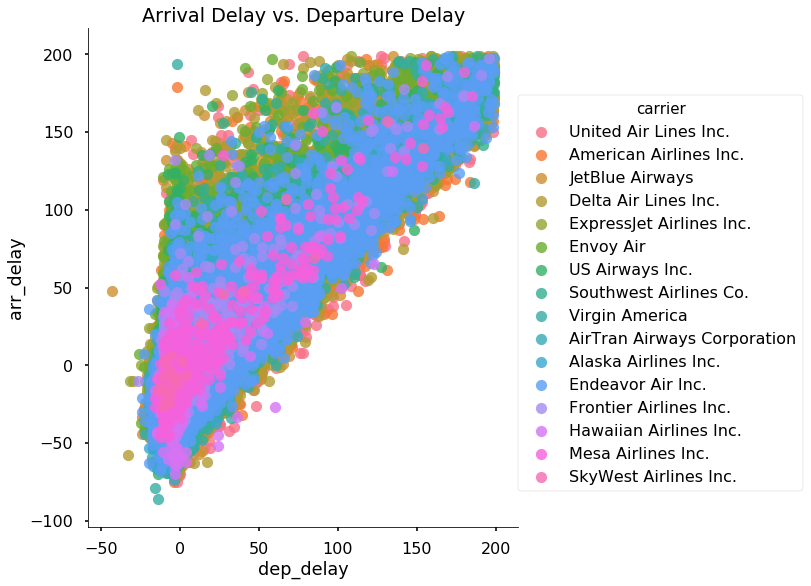

In [92]:
sns.lmplot('dep_delay', 'arr_delay', flights, 
           fit_reg = False, hue = 'carrier', size = 8);
plt.title('Arrival Delay vs. Departure Delay');

The relationship between departure and arrival delay looks to be nearly 1:1.  

In [93]:
# Restrict to first 10000 flights 
flights = flights.sample(frac=1, random_state=50)[:10000]

# Create carrier look up dict and list of codes
carriers = flights['carrier'].unique()
carrier_lookup = dict(zip(carriers, range(len(carriers))))
carrier_codes = flights['carrier_code'] = flights['carrier'].replace(carrier_lookup).values

# Pooled Model for Flight Delay

The first model will consider all of the flights together. This is a linear regression, so we are trying to find the slope of the relationship between arrival delay and departure delay. We will also find the intercept, which in this problem represents the arrival delay with no departure delay. 

In [94]:
dep = np.array(flights['dep_delay'].values)
arr = np.array(flights['arr_delay'].values)

We will approximate the arrival and departure delays as normal distributions. 

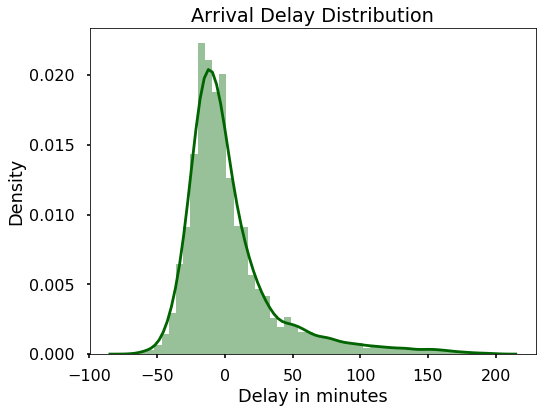

In [95]:
plt.figure(figsize=(8, 6))
sns.distplot(arr, color = 'darkgreen')
plt.title('Arrival Delay Distribution');
plt.xlabel('Delay in minutes'); plt.ylabel('Density');

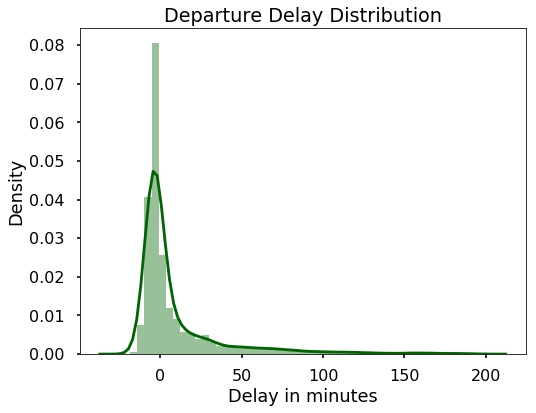

In [96]:
plt.figure(figsize=(8, 6))
sns.distplot(dep, color = 'darkgreen')
plt.title('Departure Delay Distribution');
plt.xlabel('Delay in minutes'); plt.ylabel('Density');

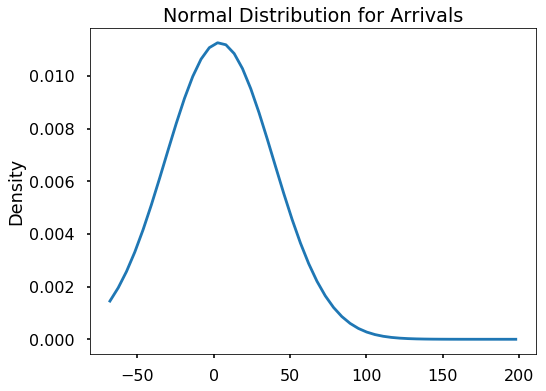

In [99]:
plt.figure(figsize=(8, 6))
x = np.linspace(min(arr), max(arr))
y = scipy.stats.norm.pdf(x, loc = np.mean(arr),scale = np.std(arr))
plt.plot(x, y);
plt.title('Normal Distribution for Arrivals')
plt.ylabel('Density');

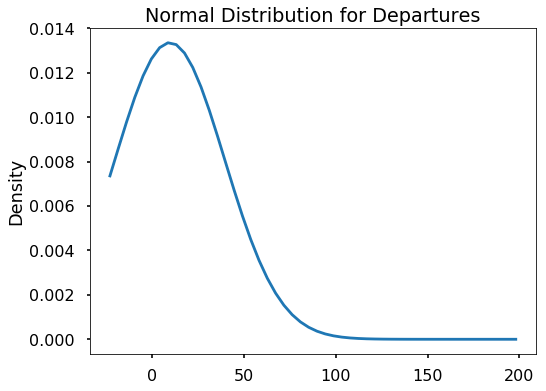

In [100]:
plt.figure(figsize=(8, 6))
x = np.linspace(min(dep), max(dep))
y = scipy.stats.norm.pdf(x, loc = np.mean(dep),scale = np.std(dep))
plt.plot(x, y);
plt.title('Normal Distribution for Departures')
plt.ylabel('Density');

In [101]:
print('Correlation between departure delay and arrival delay: {:.4f}.'.
      format(np.corrcoef(arr, dep)[0][1]))
print('Skew of Arrival Delay: {:.4f}.'.format(scipy.stats.skew(arr)))
print('Average Delay Time: {:.4f} minutes.'.format(np.mean(arr)))

Correlation between departure delay and arrival delay: 0.8631.
Skew of Arrival Delay: 2.0803.
Average Delay Time: 3.7169 minutes.


The pooled model treats all flights as coming from the same distribution. We estimate one slope and one intercept for all of the flights regardless of carrier. The equation for this model is 
$$y_i = \alpha + \beta x_i + \epsilon_i$$

Where we have an intercept, slope (relationship between the arrival and departure delay) and a model error.

In [102]:
# Treat all of observations as coming from same distribution
with pm.Model() as pooled_model:
    
    # Beta is vector of model parameters: [intercept, slope]
    beta = pm.Normal('beta', testval = [0, np.corrcoef(arr, dep)[0][1]],
                     mu = 0, sd = 10, shape=2)
    
    # Sigma is standard deviation of observations
    sigma = pm.HalfCauchy('sigma', 5)
    
    # Linear equation for the arrival delay based on departure delay
    theta = beta[0] + beta[1] * dep
    
    # The arrival delays are assumed to be normally distributed
    y = pm.Normal('y', mu=theta, sd=sigma, observed=arr)
    
    # Trace from pooled model
    pooled_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, beta]
The acceptance probability does not match the target. It is 0.8879969192014109, but should be close to 0.8. Try to increase the number of tuning steps.


In [103]:
# Intercept and slope are mean of traces
pooled_intercept, pooled_slope = pooled_trace['beta'].mean(axis=0)
pooled_sigma = pooled_trace['sigma'].mean(axis=0)

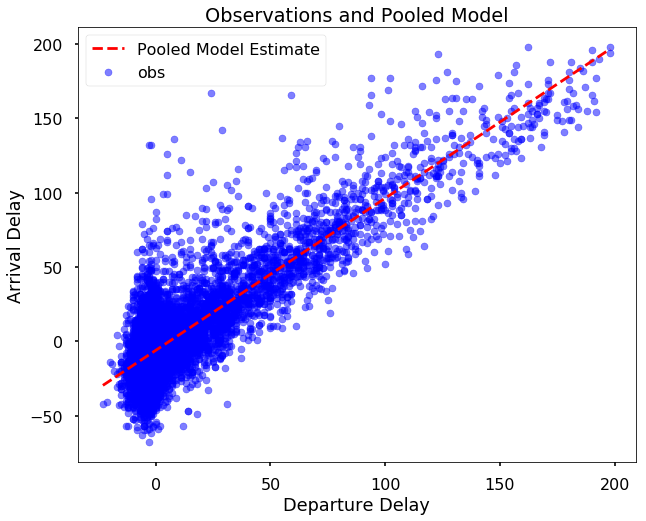

In [106]:
figsize(10, 8)

# Observations on a scatter plot
plt.scatter(flights['dep_delay'], (flights['arr_delay']), s = 50, 
           alpha = 0.5, facecolor = 'b', edgecolors = 'b', label='obs')

xvals = np.linspace(min(dep), max(dep))

# Line represents the model from sampling
plt.plot(xvals, pooled_slope * xvals + pooled_intercept, 
         'r--', label = 'Pooled Model Estimate');
plt.xlabel('Departure Delay'); plt.ylabel('Arrival Delay');
plt.legend(loc=2);
plt.title('Observations and Pooled Model');

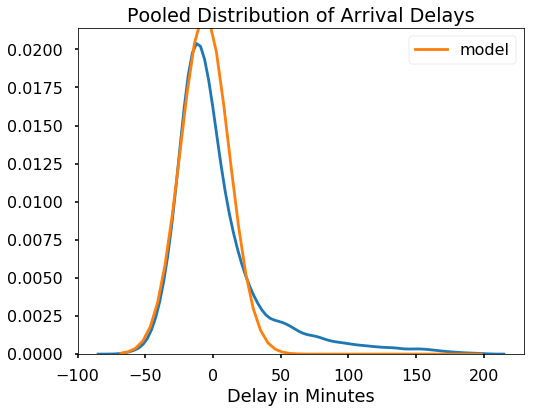

In [109]:
figsize(8, 6)
x = np.linspace(min(arr), max(arr))
pooled_dist = scipy.stats.norm.pdf(x, loc = pooled_intercept, 
                                      scale = pooled_sigma)
sns.kdeplot(arr)
plt.plot(x, pooled_dist, label='model')
plt.legend(); plt.xlabel('Delay in Minutes');
plt.title('Pooled Distribution of Arrival Delays');

The complete pooling model aligns with all of the observations. Next, we will move on to unpooled models and treating each carrier group separately.

# Completely Unpooled Model

In the no pooling model, all groups are treated separately with no dependence between the clusters. Each carrier will have its own slope describing the relationship between the departure and arrival delay. The equation for an unpooled model is:

$$y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i$$

Where $j = 1, \ldots, n$ for the number of carriers.

In [110]:
carriers

array(['Delta Air Lines Inc.', 'American Airlines Inc.',
       'Endeavor Air Inc.', 'United Air Lines Inc.',
       'ExpressJet Airlines Inc.', 'US Airways Inc.', 'JetBlue Airways',
       'Southwest Airlines Co.', 'Virgin America',
       'AirTran Airways Corporation', 'Envoy Air',
       'Frontier Airlines Inc.', 'Alaska Airlines Inc.',
       'Hawaiian Airlines Inc.', 'Mesa Airlines Inc.'], dtype=object)

In [111]:
with pm.Model() as unpooled_model:
    
    # Random Intercept
    beta0 = pm.Normal('beta0', 0, sd = 10, shape = len(carriers))
    
    # Slope
    beta1 = pm.Normal('beta1', 0, testval = np.corrcoef(arr, dep)[0][1], sd = 10)
    
    # Error for model
    sigma = pm.HalfCauchy('sigma', 5)
    
    # Model
    theta = beta0[carrier_codes] + beta1 * dep
    
    # Observations
    y = pm.Normal('y', theta, sd = sigma, observed = arr)
    unpooled_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, beta1, beta0]


To visualize the unpooled model results, we can examine the intercepts that were found for each airline. The slope is shared among the airlines, but the intercepts are completely independent. 

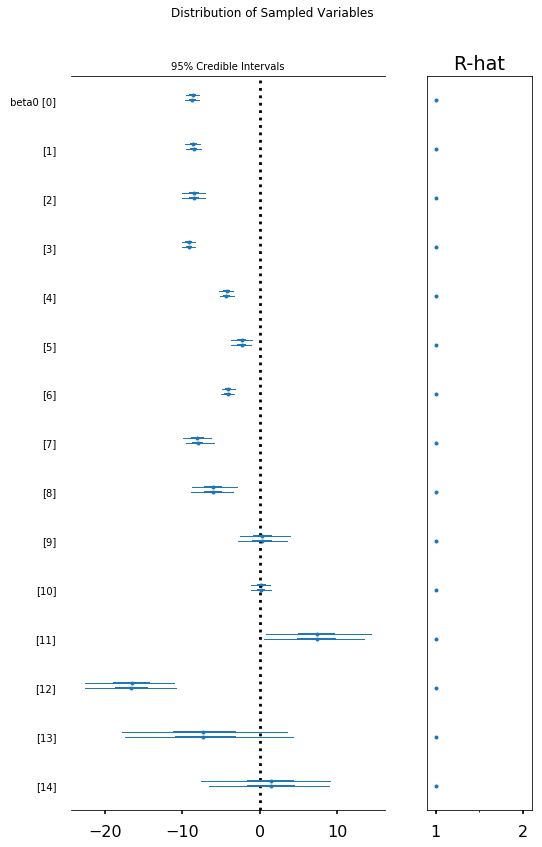

In [112]:
from pymc3 import forestplot

figsize(8, 12)
forestplot(unpooled_trace, varnames=['beta0']);
plt.suptitle('Distribution of Sampled Variables');

The intercepts differ by airline. The "best" airlines are those with the lowest intercept which represents the arrival delay with no departure delay. We can visualize this by ordering the airlines from the lowest to the highest intercept. 

In [114]:
unpooled_estimates = pd.Series(unpooled_trace['beta0'].mean(axis=0), index = carriers)
unpooled_se = pd.Series(unpooled_trace['beta0'].std(axis=0), index = carriers)

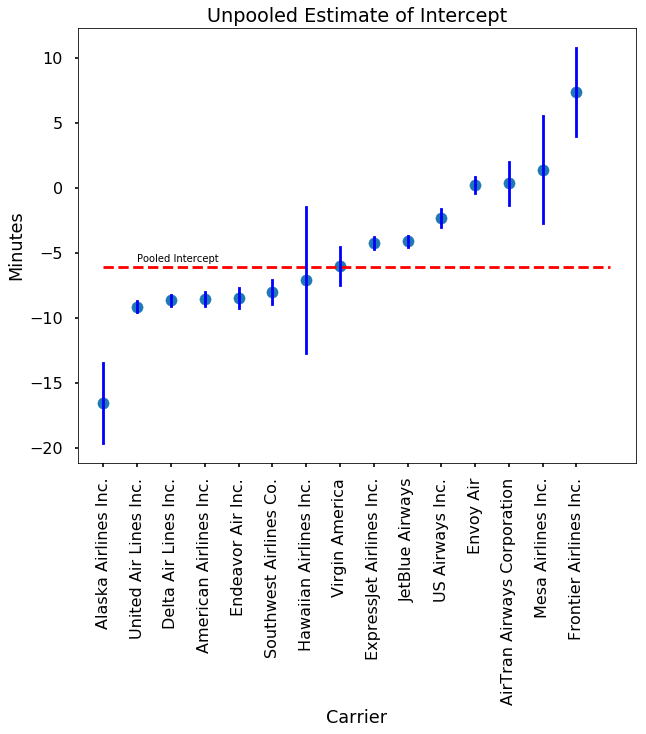

In [116]:
order = unpooled_estimates.sort_values().index
figsize(10, 8)
plt.scatter(range(len(unpooled_estimates)), unpooled_estimates[order])
for i, m, se in zip(range(len(unpooled_estimates)), unpooled_estimates[order], unpooled_se[order]):
    plt.plot([i, i], [m - se, m + se], 'b-')
    
plt.xticks(range(len(unpooled_estimates)), order, rotation = 90);
plt.hlines( y = pooled_intercept, color = 'r', linestyles='--', xmin = 0, xmax = len(unpooled_estimates))
plt.text(x = 1, y = pooled_intercept + .4, s = 'Pooled Intercept')
plt.xlabel('Carrier'); plt.ylabel('Minutes');
plt.title('Unpooled Estimate of Intercept');

Based on the unpooled model, Alaska Airlines is the best in terms of arrival delays, and Frontier Arlines is the worse in terms of arrival delays. 

We can also plot the pooled and unpooled models on the same graph for several airlines. Airlines with unpooled estimates for the intercept lower than the average are "better" because the intercept represents the arrival delay with no departure delay.

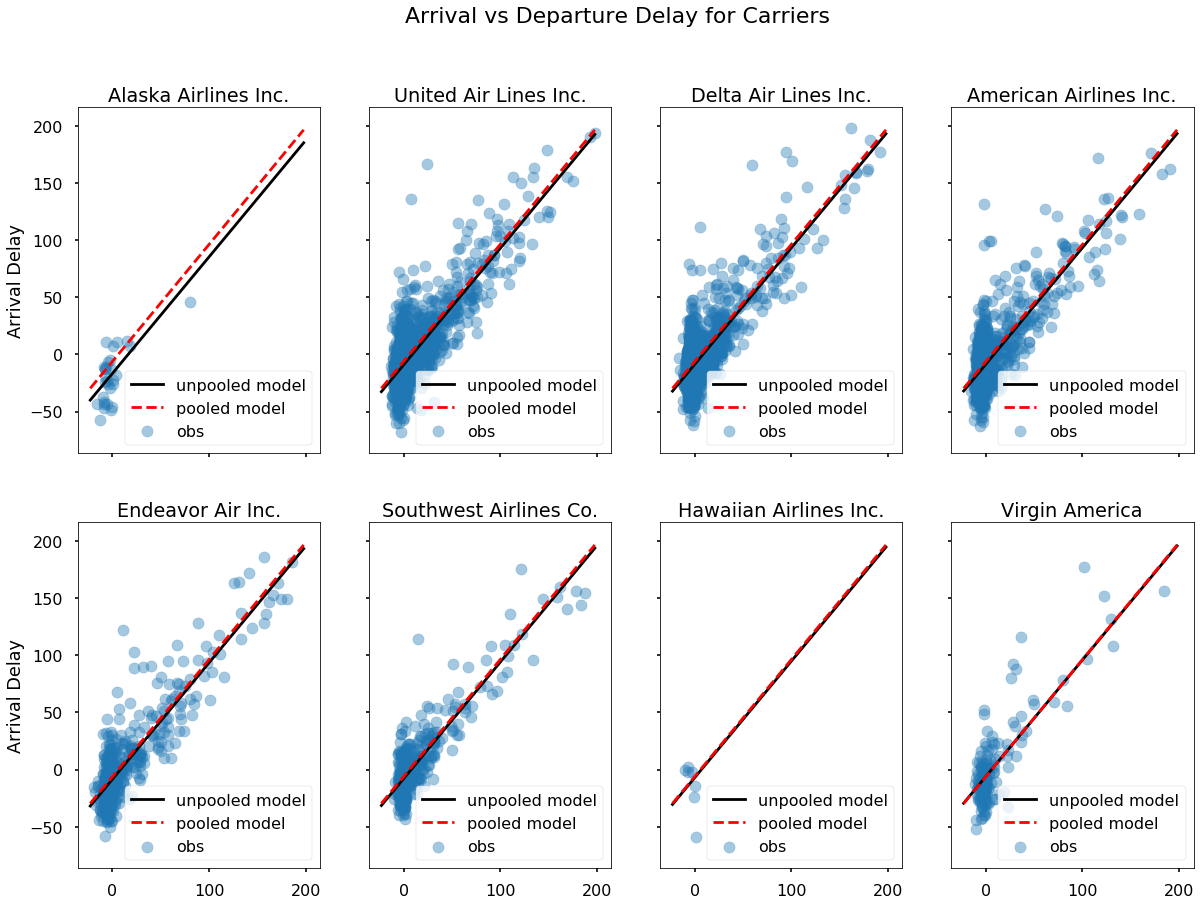

In [117]:
sample_airlines = tuple(order[:8])

fig, axes = plt.subplots(2, 4, figsize=(20, 14), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_trace['beta1'].mean()

for i,c in enumerate(sample_airlines):
    y = flights['arr_delay'][flights['carrier']==c]
    x = flights['dep_delay'][flights['carrier']==c]
    
    axes[i].scatter(x, y, alpha=0.4, label = 'obs')
    
    # No pooling model
    b = unpooled_estimates[c]
    # Plot both models and data
    xvals = np.linspace(min(dep), max(dep))
    axes[i].plot(xvals, m*xvals+b, label = 'unpooled model', color = 'k')
    axes[i].plot(xvals, pooled_slope*xvals+pooled_intercept, 'r--',
                label = 'pooled model')
    axes[i].set_title(c)
    axes[i].legend()
    if not i%4:
        axes[i].set_ylabel('Arrival Delay')
    
plt.suptitle('Arrival vs Departure Delay for Carriers', size = 22);

# Partial Pooling

Partial pooling can be done several ways. The first method, we will use no predictore and simply come up with a posterior estimate for the arrival delay based on the arrival delay observations. Therefore, we are assuming that arrival delay is not dependent on departure delay in this model. We can then examine the arrival delays to find the airline with the longest arrival delay on average.

## No predictors

The first model will use no predictors, that is, we are approximating the arrival delay based only on the data. This is accomplished using a weighted average, where we use both the carrier and overall observations with the carrier observations waited by the number of observations. Airlines with more flights will be less influenced by the overall average, while those with few observations will be heavily dependent on the overall estimate. The advantage of this approach is we can come up with reasonable estimes for groups that have few observations, although we expect them to have more uncertainty. The equation for this model is: 

$$\hat{\alpha} \approx \frac{(n_j/\sigma_y^2)\bar{y}_j + (1/\sigma_{\alpha}^2)\bar{y}}{(n_j/\sigma_y^2) + (1/\sigma_{\alpha}^2)}$$

where the estimate is a weighted average of within-group and overall observations.

In [118]:
with pm.Model() as partial_pooling:
    
    # Priors
    mu_a = pm.Normal('mu_a', mu=0, sd=10)
    sigma_a = pm.HalfCauchy('sigma_a', beta = 5)
    
    # Random intercepts
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=len(carriers))

    # Expected Value
    y_hat = a[carrier_codes]
    
    # Model Error
    sigma_y = pm.HalfCauchy('sigma_y', 5)
    
    # Likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sd=sigma_y, observed=arr)
    
    partial_pooling_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y_log__, a, sigma_a_log__, mu_a]


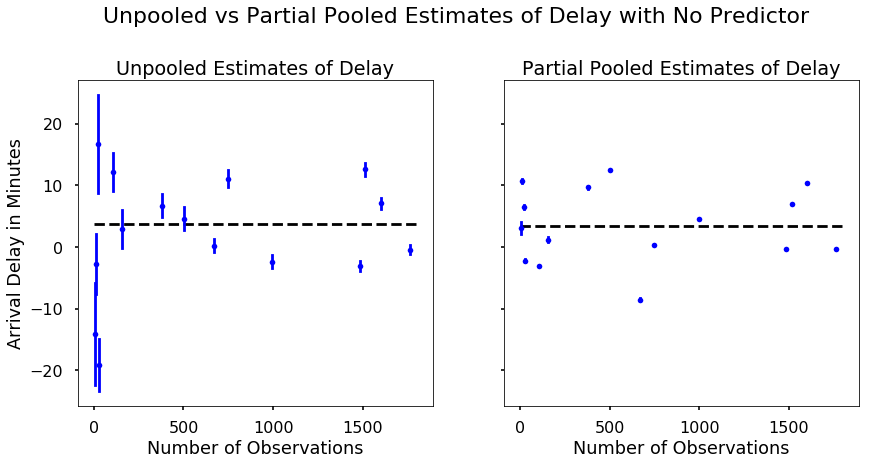

In [130]:
sample_trace = partial_pooling_trace['a']

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

samples, n_carriers = sample_trace.shape

count_carriers = flights.groupby('carrier')['arr_delay'].count()
unpooled_means = flights.groupby('carrier')['arr_delay'].mean()
unpooled_sd = flights.groupby('carrier')['arr_delay'].std()

unpooled = pd.DataFrame({'n': count_carriers, 'm': unpooled_means, 'sd': unpooled_sd})
unpooled['se'] = unpooled['sd']/np.sqrt(unpooled.n)

axes[0].plot(unpooled['n'], unpooled['m'], 'b.')
axes[0].set_ylabel('Arrival Delay in Minutes')
axes[0].set_title('Unpooled Estimates of Delay')
axes[0].set_xlabel('Number of Observations')

for row in unpooled.iterrows():
    name, dat = row
    axes[0].plot([dat['n'], dat['n']], [dat['m'] - dat['se'], dat['m'] + dat['se']], 'b-')
    
axes[0].hlines(flights['arr_delay'].mean(), 0, 1800, linestyles='--')

means = sample_trace.mean(axis=0)
sd = sample_trace.std(axis=0)
axes[1].plot(count_carriers.values, means, 'b.')

for n, m, s in zip(count_carriers.values, means, sd):
    axes[1].plot([n]*2, [m-(s/np.sqrt(n)), m+(s/np.sqrt(n))], 'b-')
    
axes[1].set_title('Partial Pooled Estimates of Delay')
axes[1].hlines(sample_trace.mean(), 0, 1800, linestyles='--')
axes[1].set_xlabel('Number of Observations')
plt.suptitle("Unpooled vs Partial Pooled Estimates of Delay with No Predictor", y = 1.05, size = 22);

The partial pooling method provides more precise estimates for all the airlines, even those with small sample sizes.

# Varying Intercept model

Another approach to partial pooling is for the airlines to share on slope, but allow the intercept to vary across carriers. The equation for this situation is: 

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

Where the delay is a function of the intercept for each airline, the common slope times the departure delay, and a model error.

In [138]:
with pm.Model() as varying_intercept:
    
    # Priors for the intercept location and standard deviation
    mu_a = pm.Normal('mu_a', mu=0, sd=10)
    sigma_a = pm.HalfCauchy('sigma_a', beta= 5)
    
    # Random intercepts for each carrier
    a = pm.Normal('a', mu = mu_a, sd = sigma_a, shape=len(carriers))
    
    # Common Slope
    b = pm.Normal('b', testval = np.corrcoef(arr, dep)[0][1], mu=0, sd=10)

    # Standard devation (error) of the model
    sd_y = pm.HalfCauchy('sd_y', beta= 5)
    
    # Estimated value for arrival delay
    y_hat = a[carrier_codes] + b * dep
    
    # Likelihood of data 
    y_like = pm.SkewNormal('y_like', mu=y_hat, sd=sd_y, observed=arr)
    
    varying_intercept_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_y_log__, b, a, sigma_a_log__, mu_a]
The acceptance probability does not match the target. It is 0.8953443305343136, but should be close to 0.8. Try to increase the number of tuning steps.


We can look at the estimates for the intercepts to see the effects of partial pooling. 

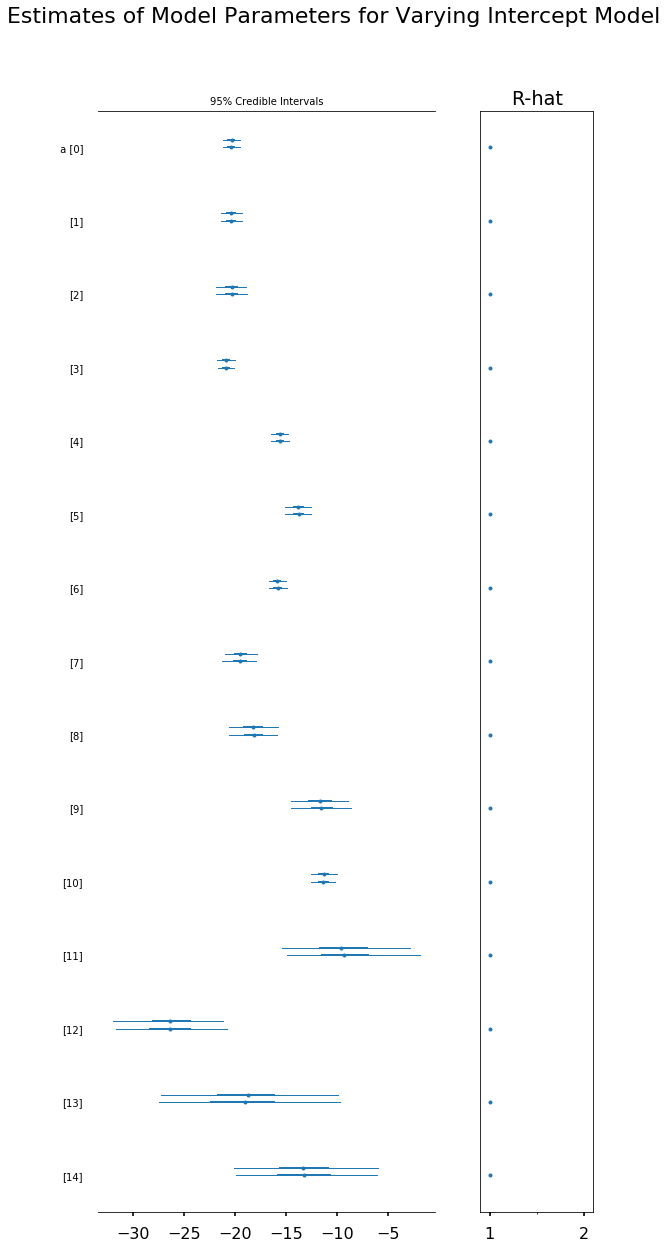

In [141]:
figsize(8, 18)
forestplot(varying_intercept_trace, varnames=['a'])
plt.suptitle('Estimates of Intercepts for Varying Intercept Model', size=22);

Another graph we can make shows the posterior for the common slope. This indicates the overall relaionship between the departure and arrival delay. 

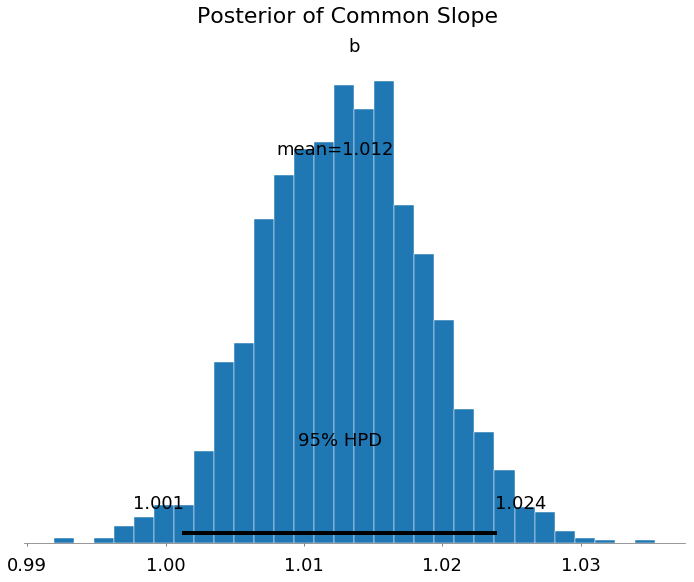

In [148]:
figsize(10, 8)
matplotlib.rcParams['font.size'] = 18
pm.plot_posterior(varying_intercept_trace, 
                 varnames = ['b']);
plt.suptitle('Posterior of Common Slope', y =1.02, size = 22);

The mean value for the overall slope is right at 1.01, indicating that for every minute of departure delay, the arrival delay increases by just over one minute. The intercepts for each airline are different in this model and provide an estimate of the arrival delay given no departure delay.

In [149]:
pm.summary(varying_intercept_trace, varnames=['b'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
b,1.012244,0.005865,0.000098,1.001339,1.023827,2000.0,0.999528


We can plot all the different models for each airline. The difference in the models is due to the varying intercept. 

In [155]:
xvals = np.linspace(min(dep), max(dep))

# Intercepts
bp = varying_intercept_trace[a].mean(axis=0)
se = varying_intercept_trace[a].std(axis=0) 

# Common mean
mp = varying_intercept_trace[b].mean()

for bi in bp:
    plt.plot(xvals, mp*xvals + bi, 'bo-', alpha = 0.2, ms = 4)

plt.xlabel('Departure Delay'); plt.ylabel('Arrival Delay')
plt.title('Estimated Arrival Delay with Varying Intercept');

AttributeError: 'dict' object has no attribute 'mean'

# Varying Slope Model

Another partial pooling model we can make has a varying slope between airlines and one common intercept. The different models represent various constraints we can place on the model. 
The varying slope model is represented by the equation: 

$$y_i = \alpha + \beta_{j[i]} x_{i} + \epsilon_i$$

Where the arrival delay is a function of the common intercept, carrier-specific slope, and model error.

In [152]:
with pm.Model() as varying_slope:
    
    # Priors for the location and standard devation of the slope
    mu_b = pm.Normal('mu_b', mu=0, sd=10)
    sigma_b = pm.HalfCauchy('sigma_b', beta=5)
    
    # Common intercept
    a = pm.Normal('a', mu = 0, sd = 10)
    
    # Slope varies between airlines
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=len(carriers))
    
    # Model error
    sigma_y = pm.HalfCauchy('sigma_y', 5)
    
    # Estimated value is function of slope and shared intercept
    y_hat = a + b[carrier_codes] * dep
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sd=sigma_y, observed=arr)
    
    varying_slope_trace = pm.sample(1000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y_log__, b, a, sigma_b_log__, mu_b]


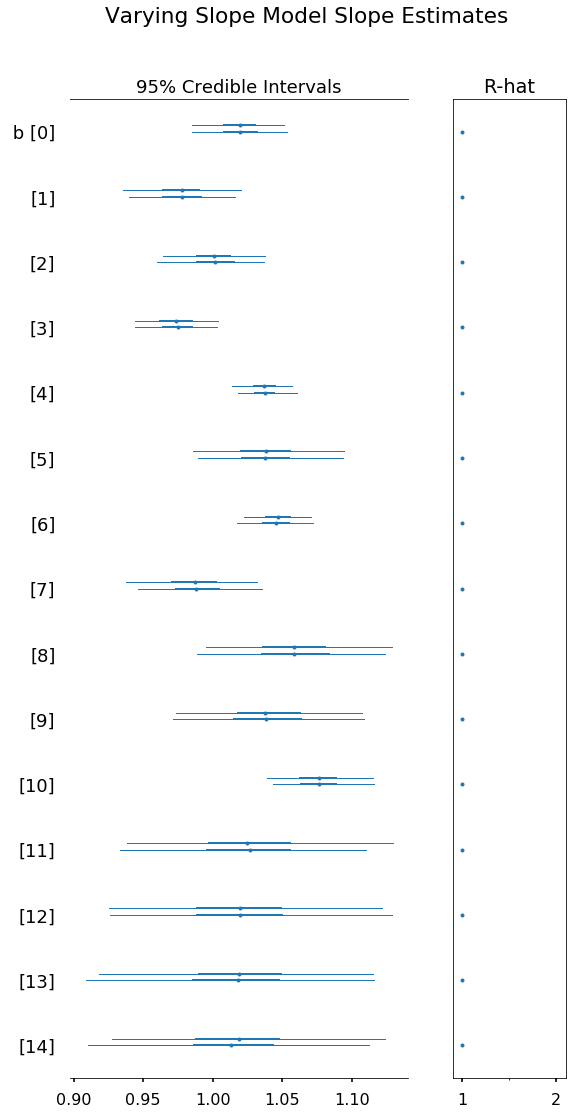

In [153]:
figsize(8, 16)
pm.forestplot(varying_slope_trace, varnames = ['b'])
plt.suptitle('Estimates of Slopes for Varying Slope Model');

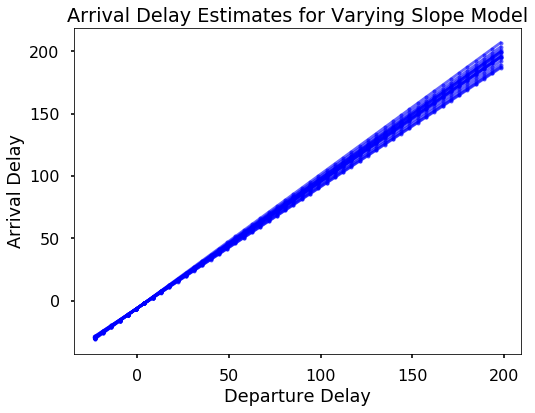

In [156]:
figsize(8, 6)

xvals = np.linspace(min(dep), max(dep))

# Common intercept
b = varying_slope_trace['a'].mean()

# Carrier specific slope
m = varying_slope_trace['b'].mean(axis=0)

for mi in m:
    plt.plot(xvals, xvals*mi + b, 'bo-', alpha=0.6, ms = 4)
    
plt.title('Arrival Delay Estimates for Varying Slope Model')
plt.xlabel('Departure Delay'); plt.ylabel('Arrival Delay');

# Varying Intercept and Slope Model

The final partial pooling model we wil look at has a varying intercept and slope for all the carrier groups. Each airline has its own intercept and slope that is a weighted average of the overall slope and intercept and the airline specific slope and intercept. The equation for this model is:

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_{i} + \epsilon_i$$

Where the arrival delay is a function of the carrier-specific intercept, the product of the carrier-specific slope and departure delay, and the model error. 

The model creation and sample is much the same as before with the freedom of both slope and intercept parameters.

In [157]:
with pm.Model() as varying_intercept_slope:
    
    # Priors for location and standard deviation of intercept
    mu_a = pm.Normal('mu_a', mu=0, sd=1e5)
    sigma_a = pm.HalfCauchy('sigma_a', beta=5)
    
    # Priors for location and standard deviation of slope
    mu_b = pm.Normal('mu_b', mu=0, sd=1e5)
    sigma_b = pm.HalfCauchy('sigma_b', beta=5)
    
    # Intercept for each carrier
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=len(carriers))
    # Slope for each carrier
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=len(carriers))
    
    # Model error
    sigma_y = pm.Uniform('sigma_y', lower=0, upper=100)
    
    # Estimate of arrival delay
    y_hat = a[carrier_codes] + b[carrier_codes] * dep
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sd=sigma_y, observed=arr)
    
    varying_intercept_slope_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y_interval__, b, a, sigma_b_log__, mu_b, sigma_a_log__, mu_a]
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7128732150425139, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


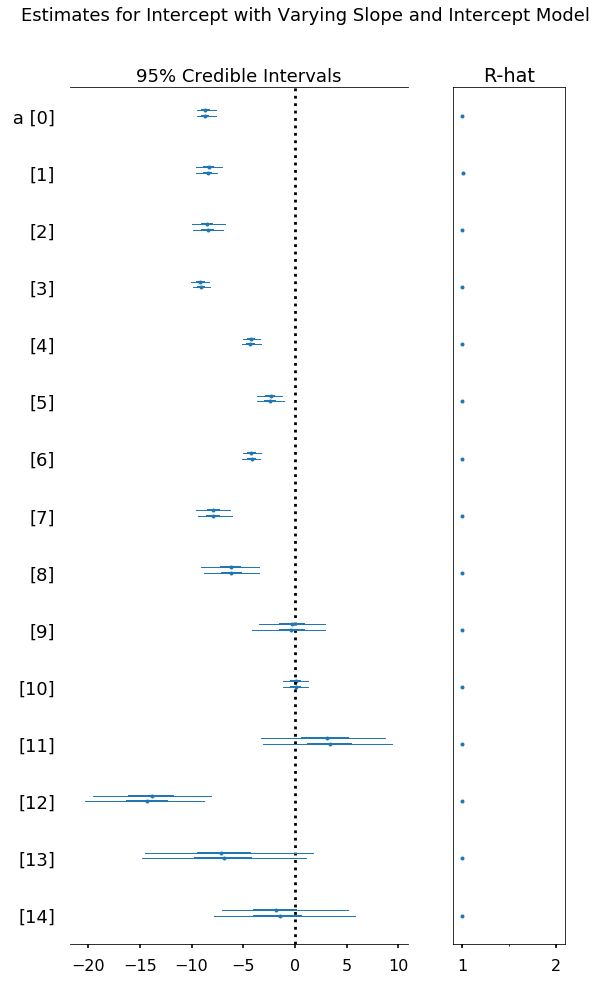

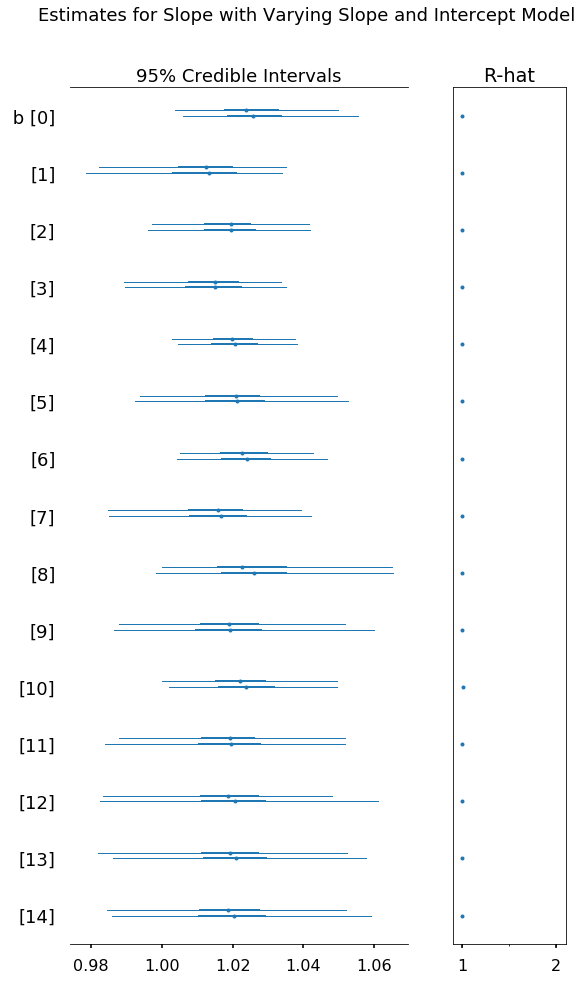

In [159]:
figsize(8, 14)
pm.forestplot(varying_intercept_slope_trace, varnames=['a']);
plt.suptitle('Estimates for Intercept with Varying Slope and Intercept Model', size=18);
plt.show();

pm.forestplot(varying_intercept_slope_trace, varnames=['b']);
plt.suptitle('Estimates for Slope with Varying Slope and Intercept Model', size=18);
plt.show();

We can visualize all of the models for each airline with differing slope and intercept. 

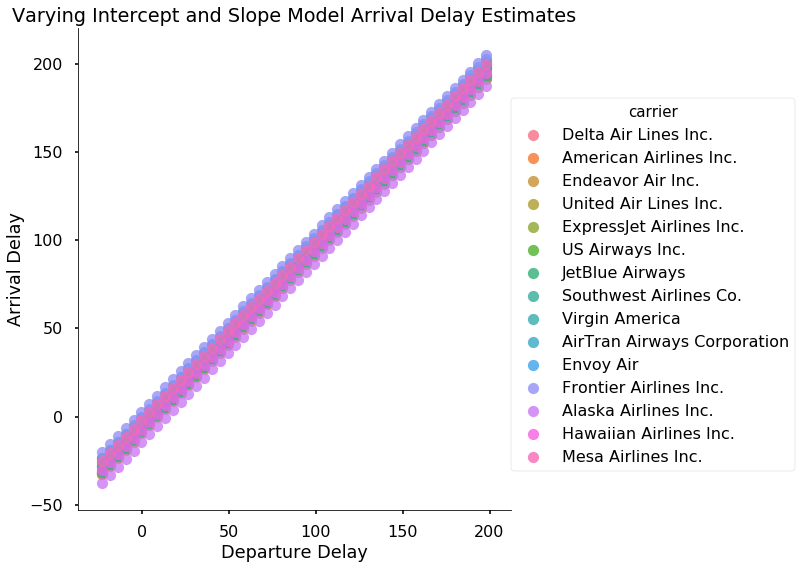

In [174]:
xvals = np.linspace(min(dep), max(dep))

b = varying_intercept_slope_trace['a'].mean(axis=0)
m = varying_intercept_slope_trace['b'].mean(axis=0)
i = list(range(len(b)))

models = pd.DataFrame(columns=['carrier', 'dep', 'arr'])

figsize(10, 8);

for bi, mi, carrier in zip(b, m, carriers):
    carrier_df = pd.DataFrame(columns=['carrier', 'dep', 'arr'])
    carrier_df['dep'] = xvals
    carrier_df['arr'] = xvals*mi + bi
    carrier_df['carrier'] = carrier
    
    models = models.append(carrier_df)

sns.lmplot('dep', 'arr', data = models, hue = 'carrier',
           fit_reg=False, size=8)
plt.title('Varying Intercept and Slope Model Arrival Delay Estimates');
plt.xlabel('Departure Delay'); plt.ylabel('Arrival Delay');

# Conclusions

In this notebook we examined several approaches for hierarchical modeling. Our goal was to create a linear model mapping departure delay to arrival delay for airline flights. 
We created numerous different models to look at the approaches for Bayesian Regression modeling:

* Pooled Model: all flights come from same model
* Unpooled Model: all parameters for each cluster are independent
* Partial Pooled Model: parameters are drawn from a population distribution and are neither identical or completely independent. There were a number of different approaches to partial pooling examined:

    + No predictors: estimates for arrival delay for each airline is a weighted average of group observations and cluster observations
    + Varying Intercept: airlines share the same slope - between departure delay and arrival delay - both have different intercepts
    + Varying Slope: airlines share the same intercept but have different slopes
    + Varying Intercept and Slope: Airlines have different intercepts and slopes
    
Hierarchical Modeling is best represented by this image

![image](images/hierarchical.png)

Which shows model parameters come from a population distributionm and each group parameter describes the observations in that group. MCMC methods allow us to find those parameters by sampling from the posterior based on the freedom we give to the model. In different situations we might wish to create difference models with varying levels of independence. For example, if all flights are limited to the same speed, then than the relationship between the arrival and departure delay would have to be fixed for all airlines and any variation in arrival delay would be due to different intercepts between the airlines. 

Markov Chain Monte Carlo methods allow us to approximate the parameters for our model and are extremely useful when dealing with continuous variables. In this case, finding the posteriors by hand is impossible and so we need to use sampling methods for approximate. MCMC can be used for many different types of Bayesian Inference and we demonstrated how useful it is for creating hierarchical regression models. 